<a href="https://colab.research.google.com/github/ashishsaini01/ConvolutionNeuralNets_DeepLearning.ai/blob/master/Practice_anomaly_detection_using_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Anomaly detection using Autoencoders

In [36]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [11]:
# Dowmload and load ECG dataset (labels 0 and 1, 0 denotes the row is an anomly and 1 for the observations which are normal)

path_to_data = "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"
data_df = pd.read_csv(path_to_data, header = None)

data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [12]:
assert data_df.shape == (4998, 141) # dataset shape is not correct

In [51]:
# seprating features and target(last column is the target)
features = data_df.drop(140, axis = 1)
target = data_df[140]

# splitting data into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, stratify = target)

# Normalizing the data using MinMaxScaler
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

min_max_scaler = MinMaxScaler(feature_range = (0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [54]:
# test cases
assert features.shape == (4998, 140) # some features are missing
assert target.shape == (4998,) # target must be 1D
assert (np.unique(target) == np.array([0., 1.])).all() # Target must conatins only 2 classes
assert not x_train.shape == x_test.shape # must be not equal
assert not x_train.values == x_train_scaled # data not scaled
assert not x_train_scaled.shape == x_test_scaled.shape # must be not equal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [60]:
from tensorflow.keras import Model

In [79]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Paramerters

  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """
  def __init__(self, output_units, code_size = 8):
      super().__init__()
      self.encoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(output_units, activation = 'relu')                                         
      ])
      self.decoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(output_units, activation = 'sigmoid')                                           
      ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

model = AutoEncoder(output_units = x_train_scaled.shape[1])
# configurations of model
# model.compile(loss='msle', metrics=['mse'], optimizer='adam')
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'msle',
              metrics = [tf.keras.metrics.MeanSquaredLogarithmicError()])

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs = 20,
    batch_size = 512,
    validation_data = (x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 2s 94ms/step - loss: 0.0113 - mean_squared_logarithmic_error: 0.0113 - val_loss: 0.0139 - val_mean_squared_logarithmic_error: 0.0139
Epoch 2/20
5/5 [==============================] - 0s 30ms/step - loss: 0.0111 - mean_squared_logarithmic_error: 0.0111 - val_loss: 0.0137 - val_mean_squared_logarithmic_error: 0.0137
Epoch 3/20
5/5 [==============================] - 0s 42ms/step - loss: 0.0106 - mean_squared_logarithmic_error: 0.0106 - val_loss: 0.0134 - val_mean_squared_logarithmic_error: 0.0134
Epoch 4/20
5/5 [==============================] - 0s 54ms/step - loss: 0.0098 - mean_squared_logarithmic_error: 0.0098 - val_loss: 0.0131 - val_mean_squared_logarithmic_error: 0.0131
Epoch 5/20
5/5 [==============================] - 0s 47ms/step - loss: 0.0087 - mean_squared_logarithmic_error: 0.0087 - val_loss: 0.0130 - val_mean_squared_logarithmic_error: 0.0130
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 0.0077 - mean_

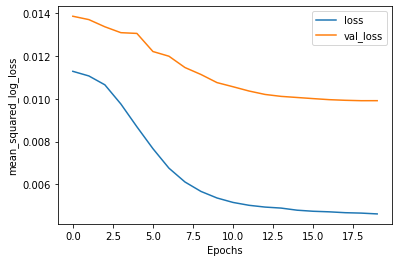

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('mean_squared_log_loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [82]:
def find_threshold(model, x_train_scaled):
  reconstruction = model.predict(x_train_scaled)

  # provides loss of individual instance
  reconstruction_error = tf.keras.losses.msle(reconstruction, x_train_scaled)

  # threshold for anomaly scores
  threshold = np.mean(reconstruction_error.numpy()) \
                  + np.std(reconstruction_error.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)

  # provides loss of individual instances
  prediction_erros = tf.keras.losses.msle(predictions, x_test_scaled)

  anomaly_mask = pd.Series(prediction_erros) > threshold

  preds = anomaly_mask.astype(int)

  return preds


In [85]:
threshold = find_threshold(model, x_train_scaled)
print(threshold)
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

0.009963506083633056


0.067

#### Reference
##### https://www.analyticsvidhya.com/blog/2021/05/anomaly-detection-using-autoencoders-a-walk-through-in-python/